## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Read Data

In [2]:
data_df = pl.read_csv(
    "https://raw.githubusercontent.com/rtdew1/rtdew1.github.io/master/ls_sim.csv",
    dtypes={"id": pl.Categorical},
)

data_df.head()

y,id,fs,t,r,l,pnum
i64,cat,i64,i64,i64,i64,i64
0,"""1""",20,21,1,1,2
0,"""1""",20,22,2,2,2
0,"""1""",20,23,3,3,2
0,"""1""",20,24,4,4,2
0,"""1""",20,25,5,5,2


## EDA

In [3]:
data_df["id"].unique().shape[0]

7969

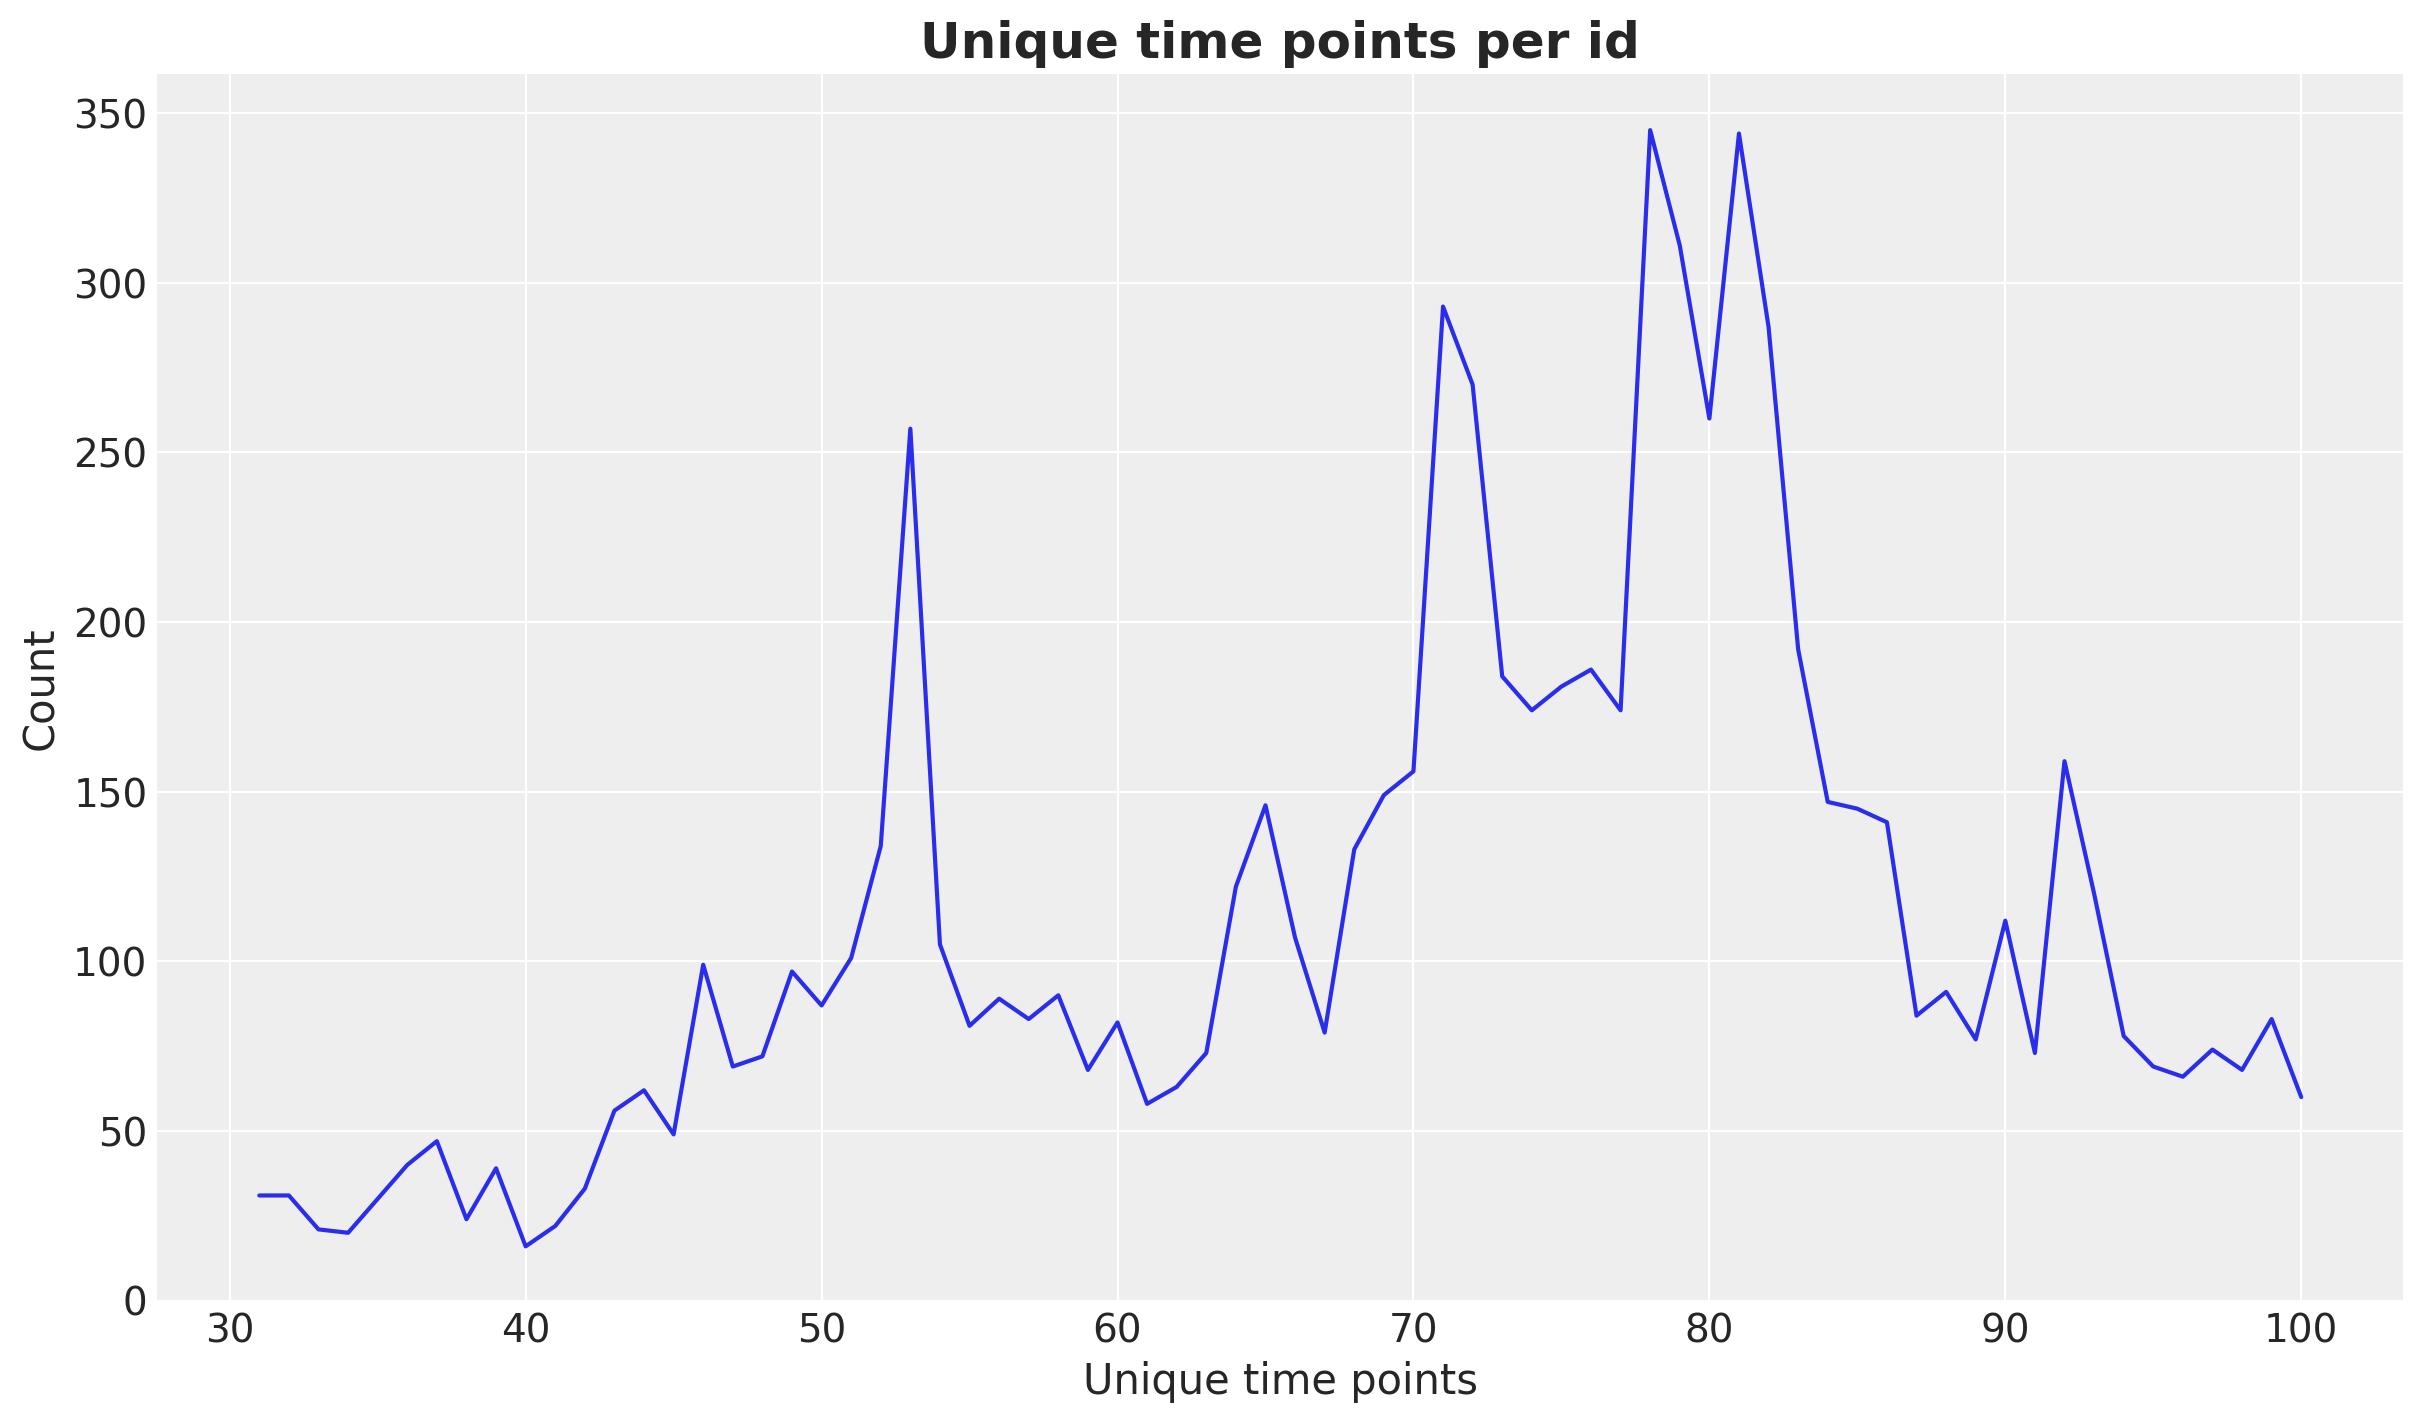

In [48]:
fig, ax = plt.subplots()
(
    data_df.group_by("id")
    .agg(pl.col("t").count().alias("t_unique"))
    .sort("t_unique")
    .group_by("t_unique")
    .agg(pl.col("id").count().alias("count"))
    .pipe(lambda df: sns.lineplot(data=df, x="t_unique", y="count", ax=ax))
)
ax.set(xlabel="Unique time points", ylabel="Count")
ax.set_title("Unique time points per id", fontsize=18, fontweight="bold");

In [55]:
(
    data_df.group_by("id")
    .agg(pl.col("t").max().alias("max_t"))
    .select(pl.col("max_t").unique().alias("max_t_unique"))
)

max_t_unique
i64
100


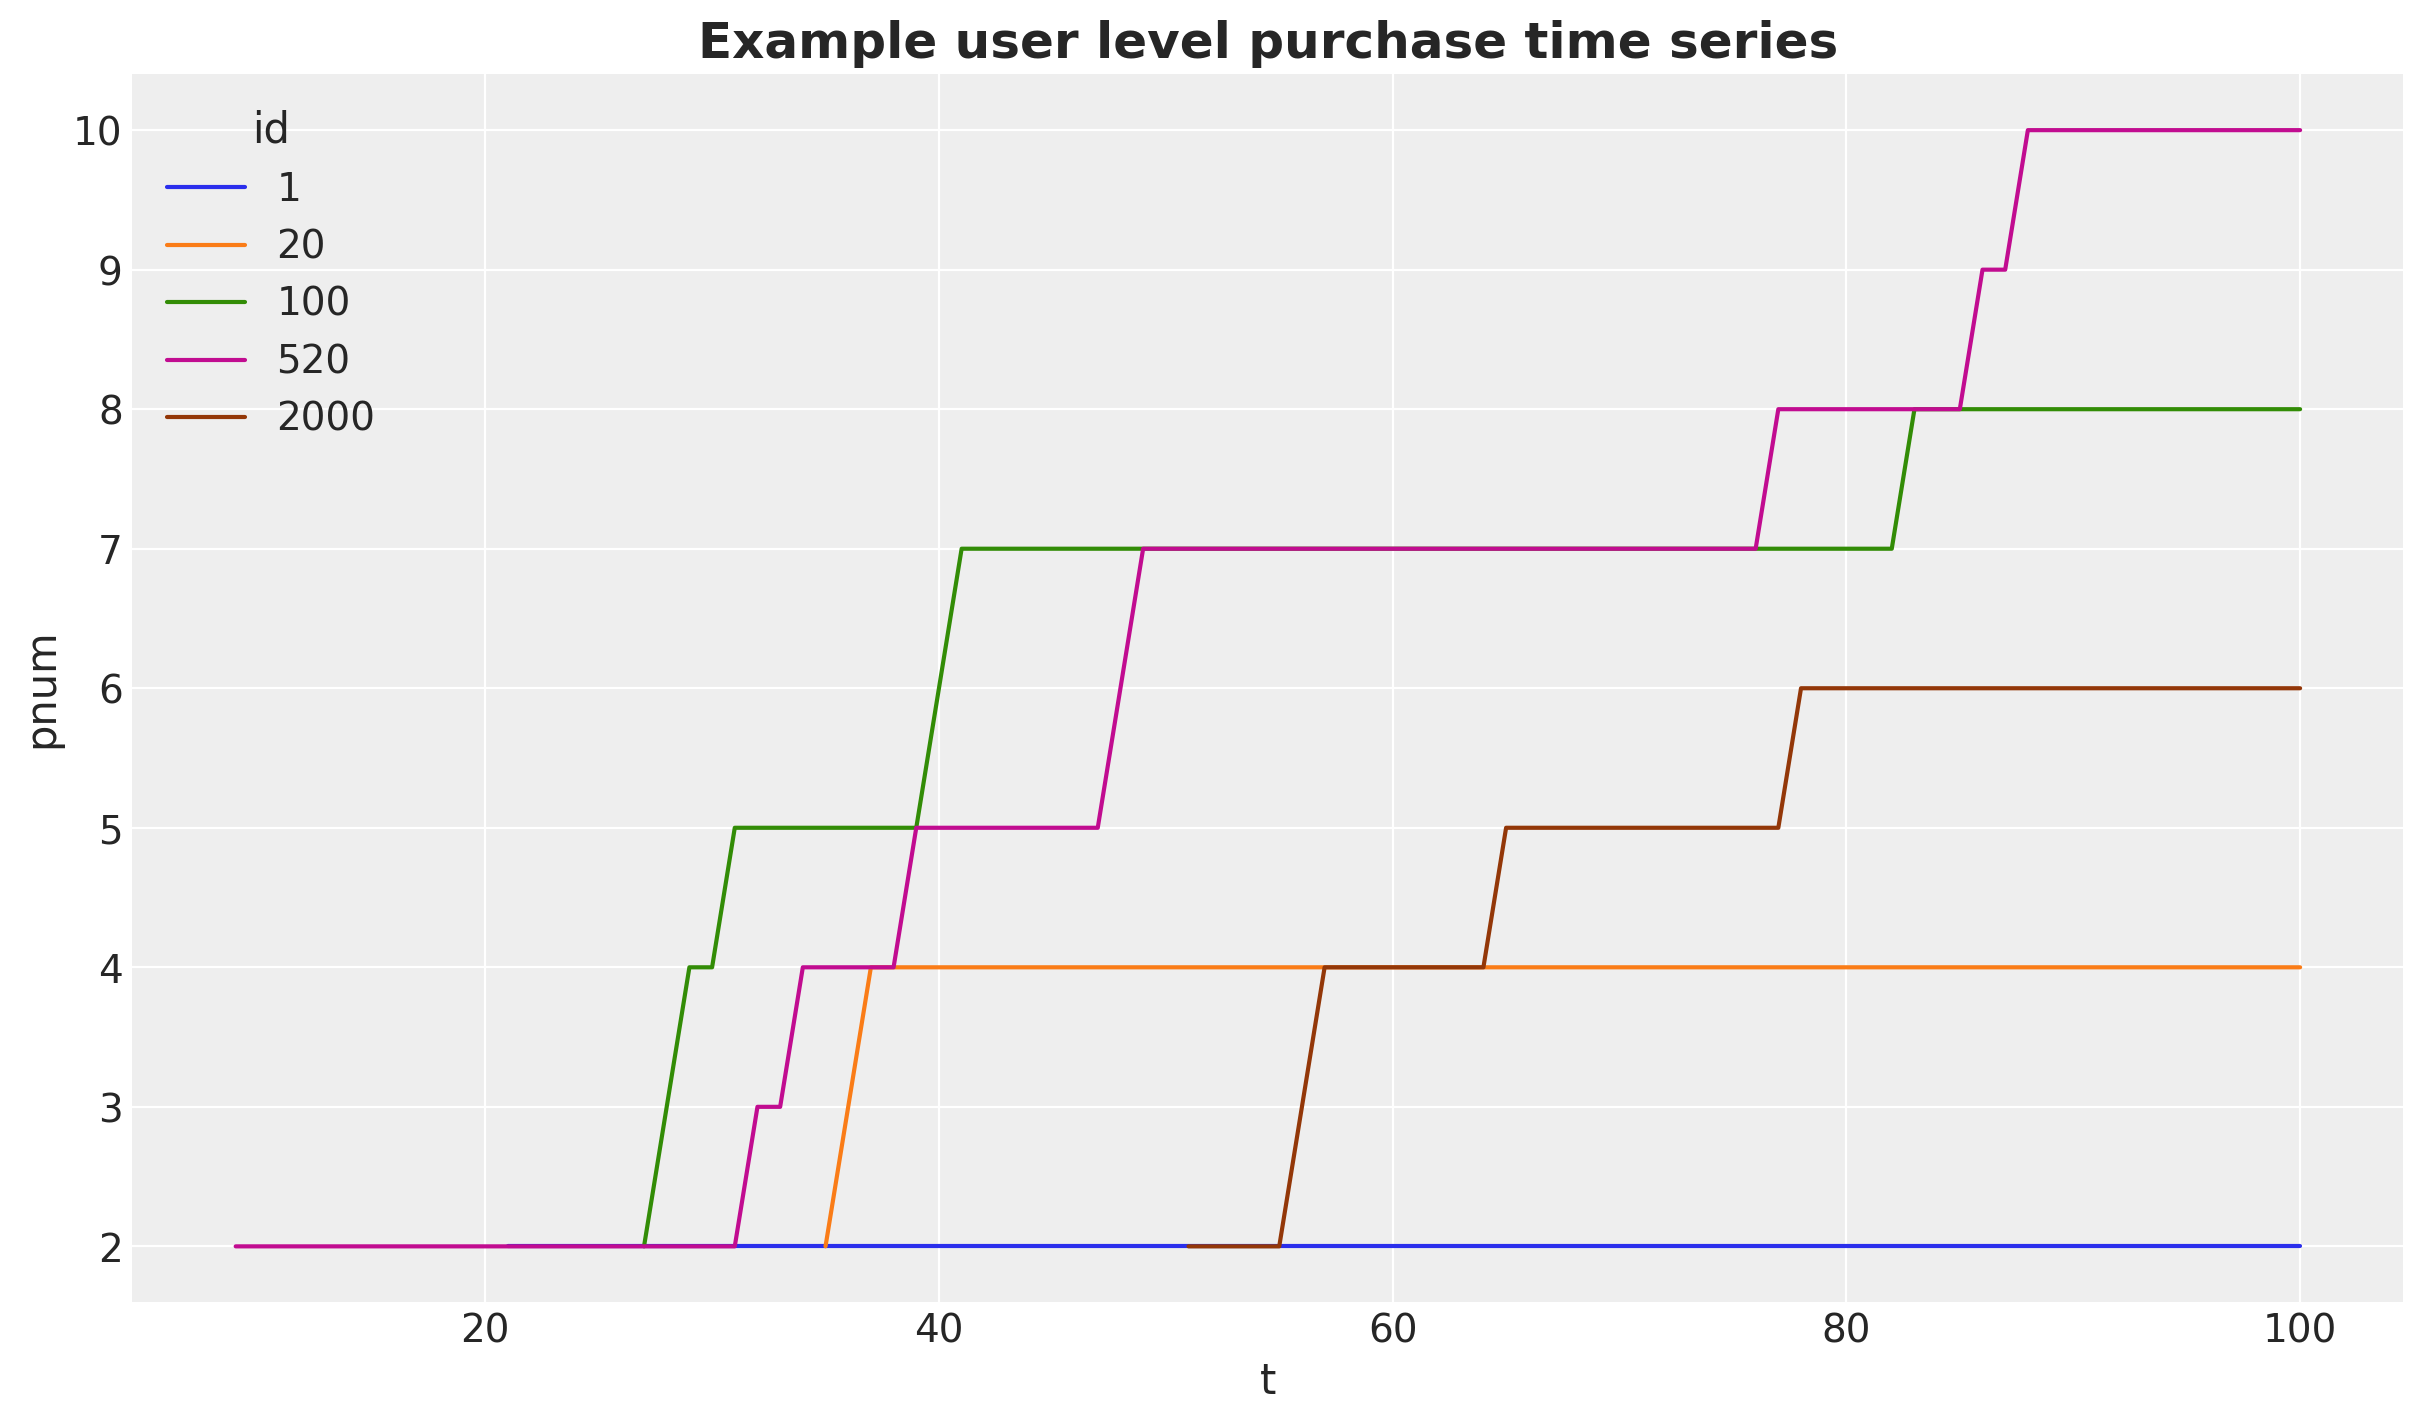

In [5]:
fig, ax = plt.subplots()
for i, idx in enumerate(["1", "20", "100", "520", "2000"]):
    sns.lineplot(
        data=data_df.filter(pl.col("id") == idx),
        x="t",
        y="pnum",
        color=f"C{i}",
        label=idx,
        ax=ax,
    )
ax.legend(title="id", title_fontsize=15, loc="upper left")
ax.set_title("Example user level purchase time series", fontsize=18, fontweight="bold");

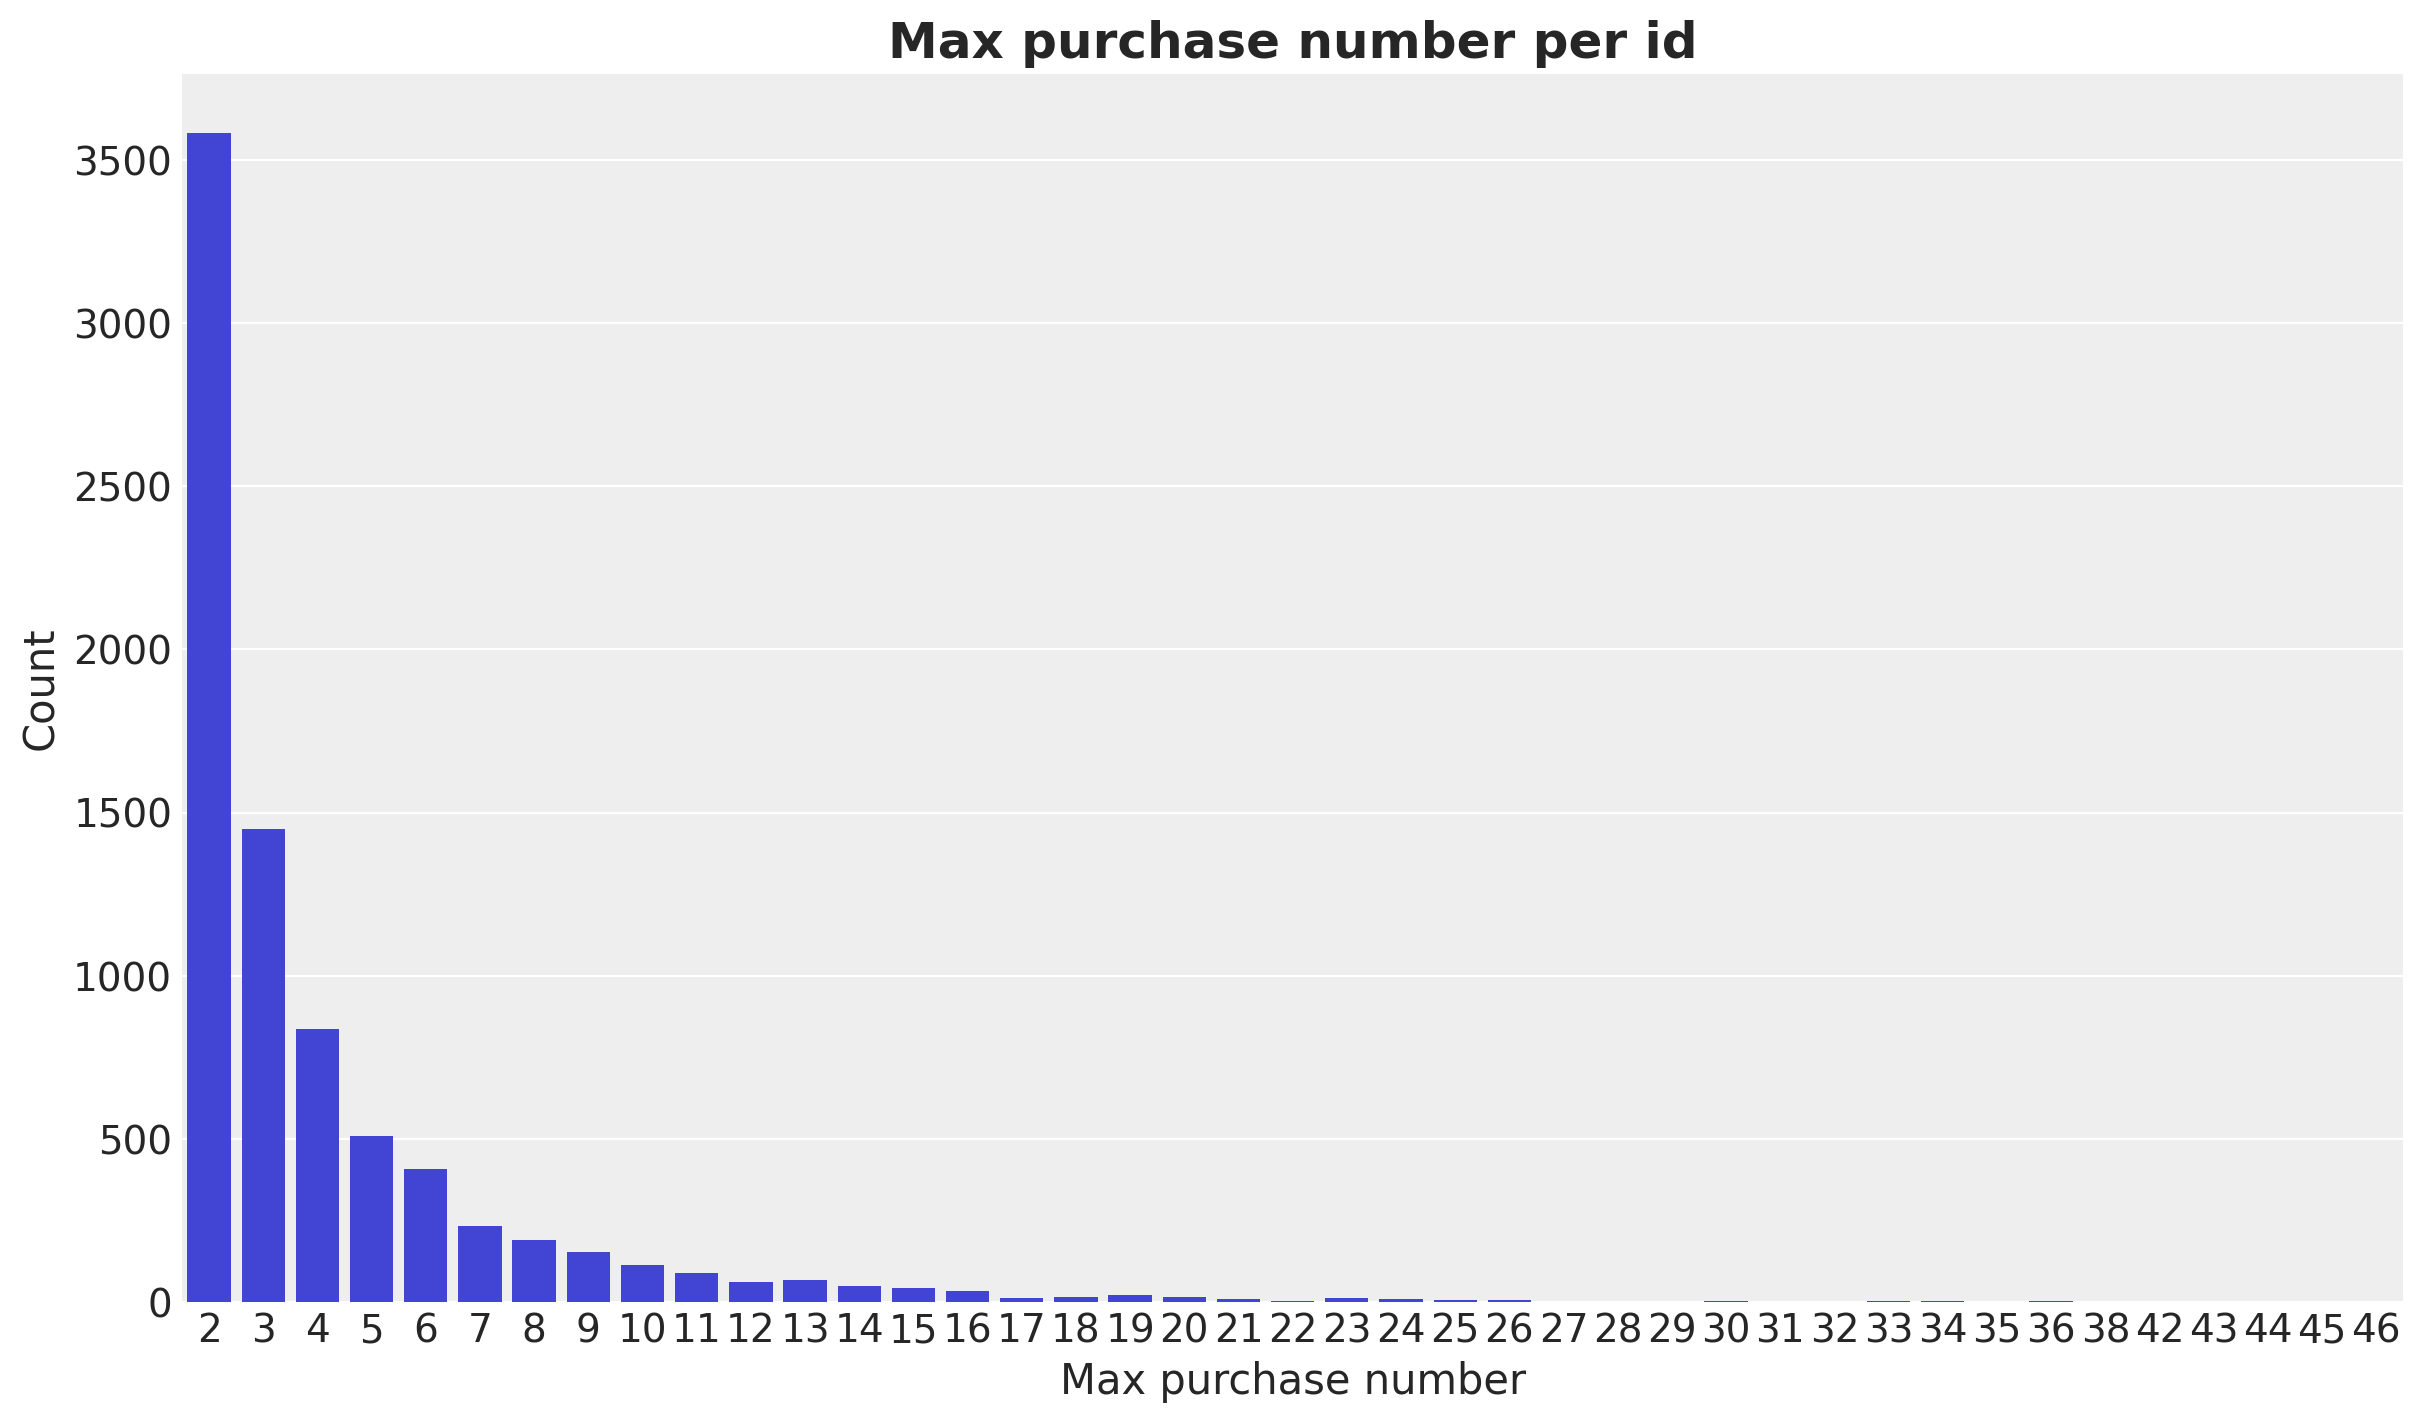

In [6]:
fig, ax = plt.subplots()
(
    data_df.group_by("id")
    .agg(pl.col("pnum").max().alias("max_pnum"))
    .group_by("max_pnum")
    .agg(pl.col("id").count().alias("count"))
    .sort("count")
    .pipe(lambda df: sns.barplot(data=df, x="max_pnum", y="count"))
)
ax.set(xlabel="Max purchase number", ylabel="Count")
ax.set_title("Max purchase number per id", fontsize=18, fontweight="bold");

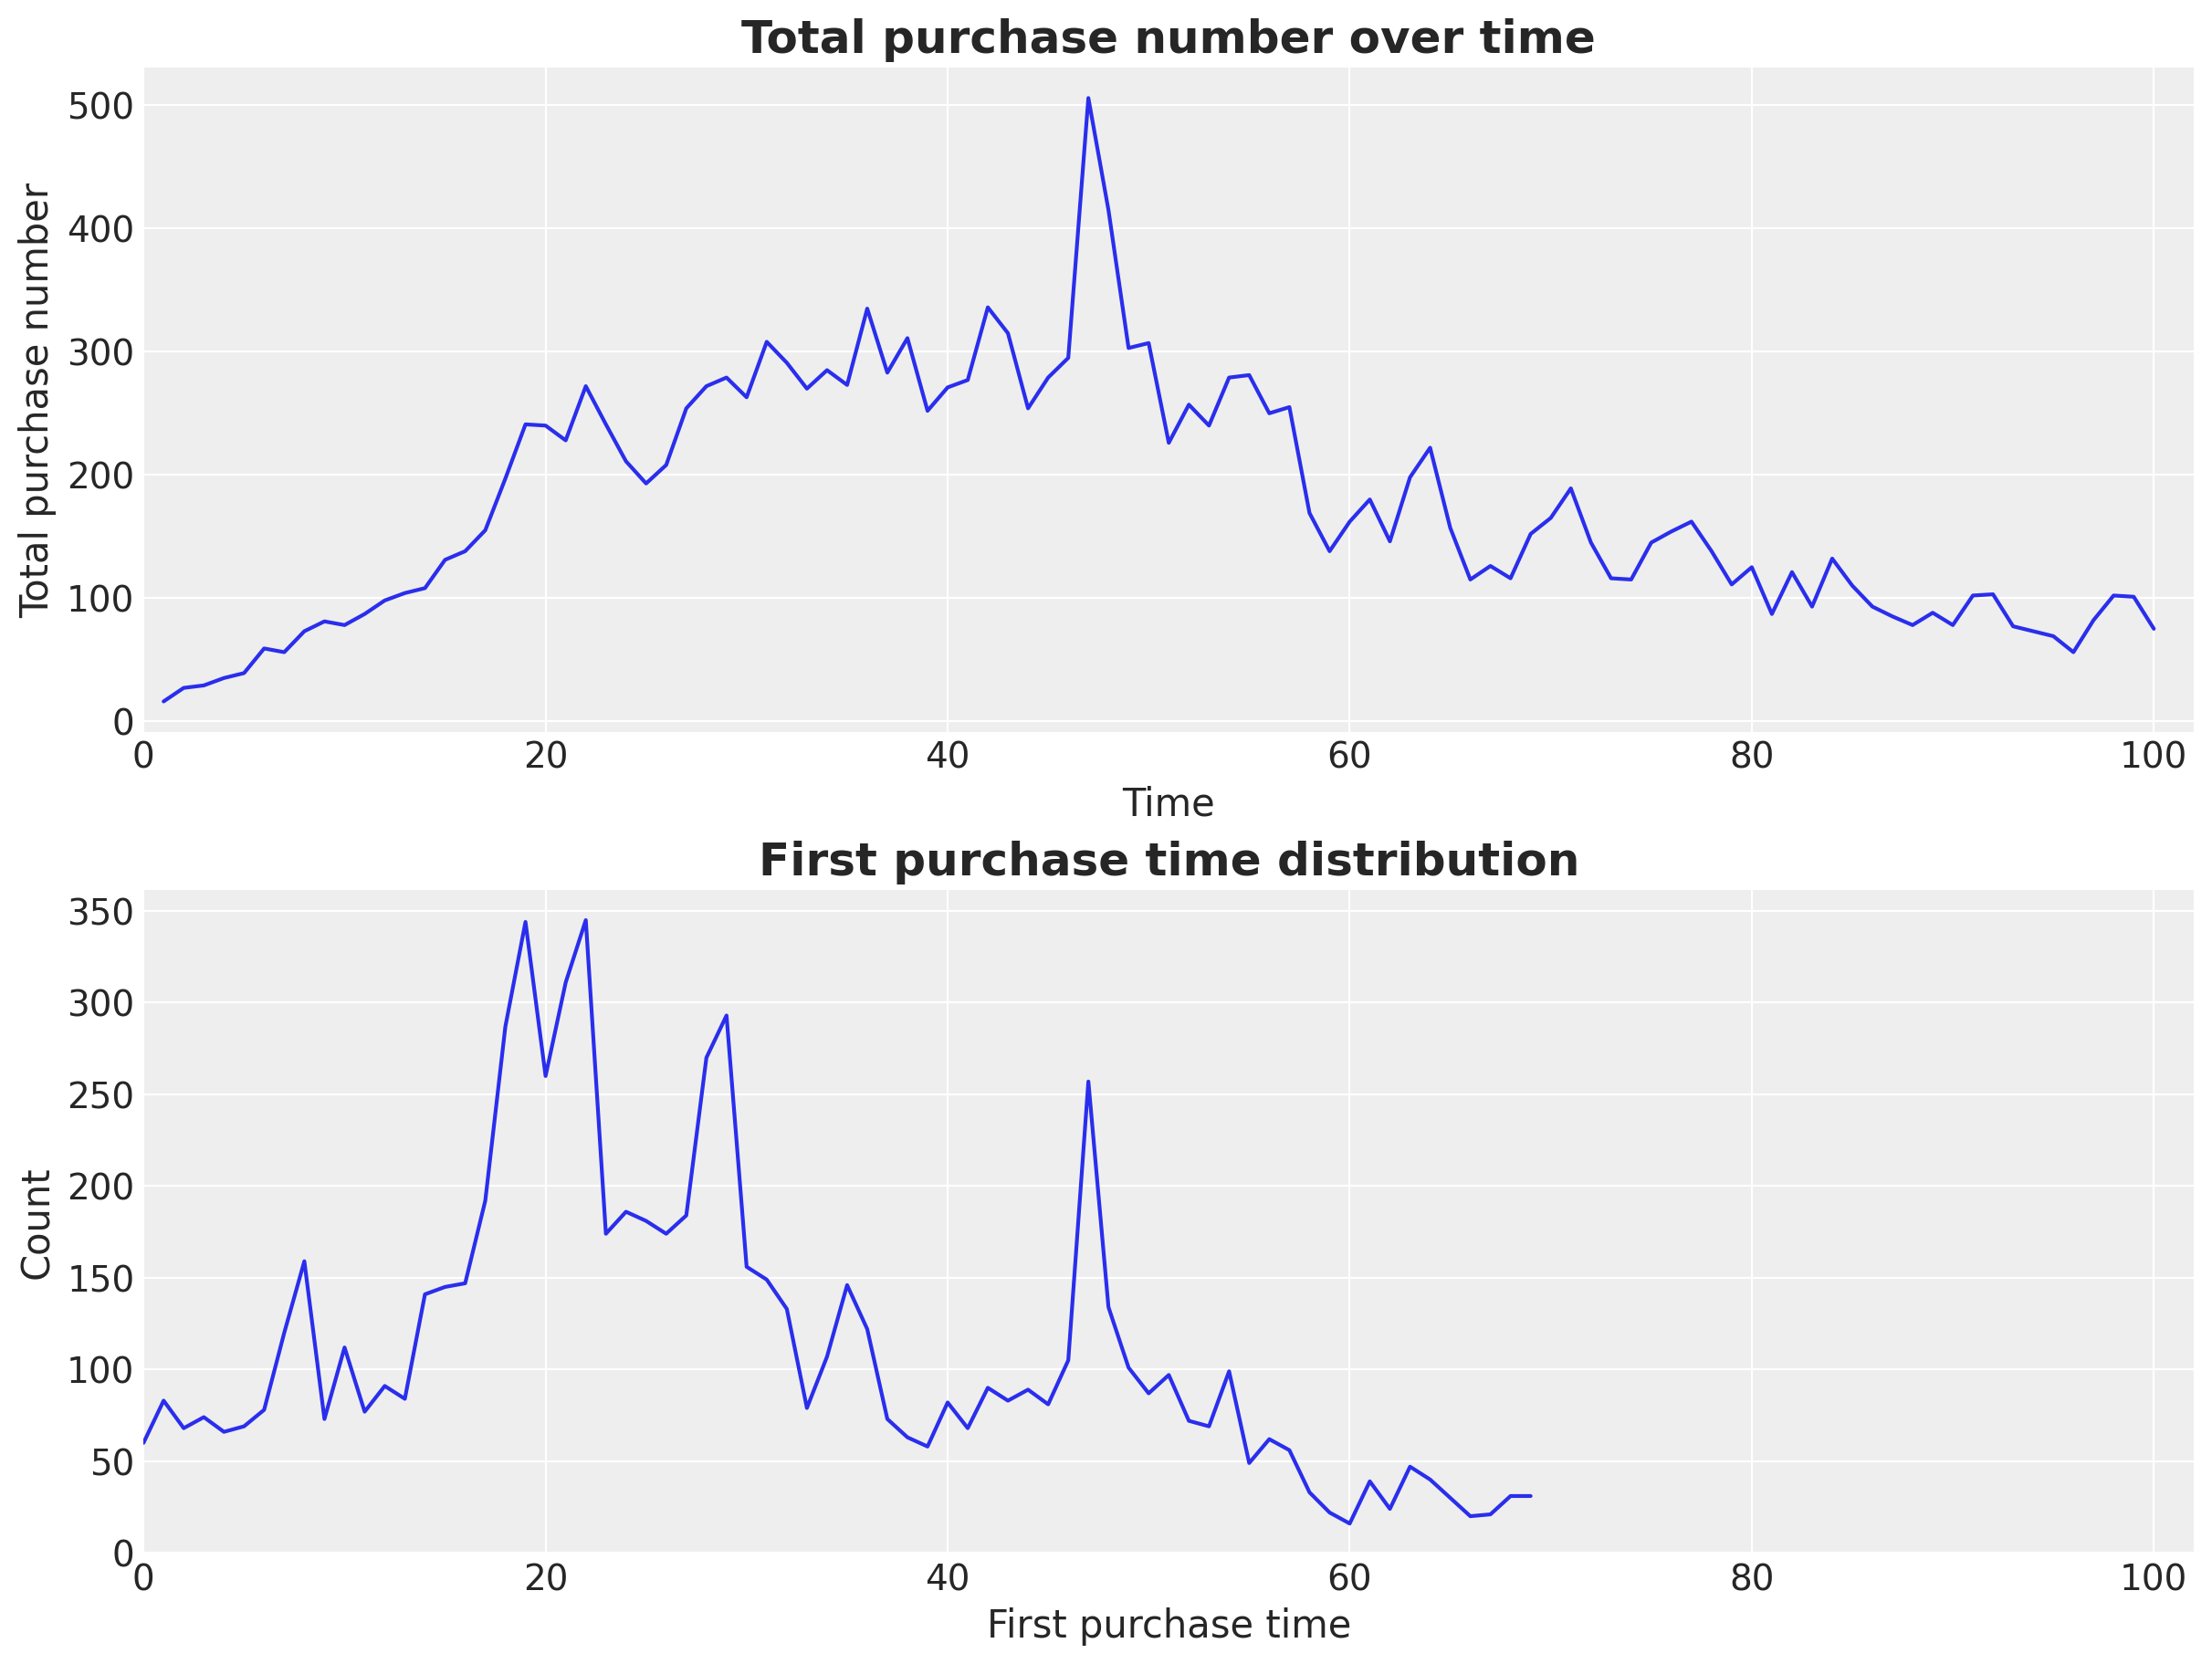

In [46]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

data_df.group_by("t").agg(pl.col("y").sum().alias("total_y")).pipe(
    lambda df: sns.lineplot(data=df, x="t", y="total_y", ax=ax[0])
)
ax[0].set(xlabel="Time", ylabel="Total purchase number", xlim=(0, 102))
ax[0].set_title("Total purchase number over time", fontsize=18, fontweight="bold")

data_df.select(pl.col("id"), pl.col("fs")).unique(subset=["id", "fs"]).group_by(
    "fs"
).len().pipe(lambda df: sns.lineplot(data=df, x="fs", y="len", ax=ax[1]))
ax[1].set(xlabel="First purchase time", ylabel="Count", xlim=(0, 102))
ax[1].set_title("First purchase time distribution", fontsize=18, fontweight="bold");

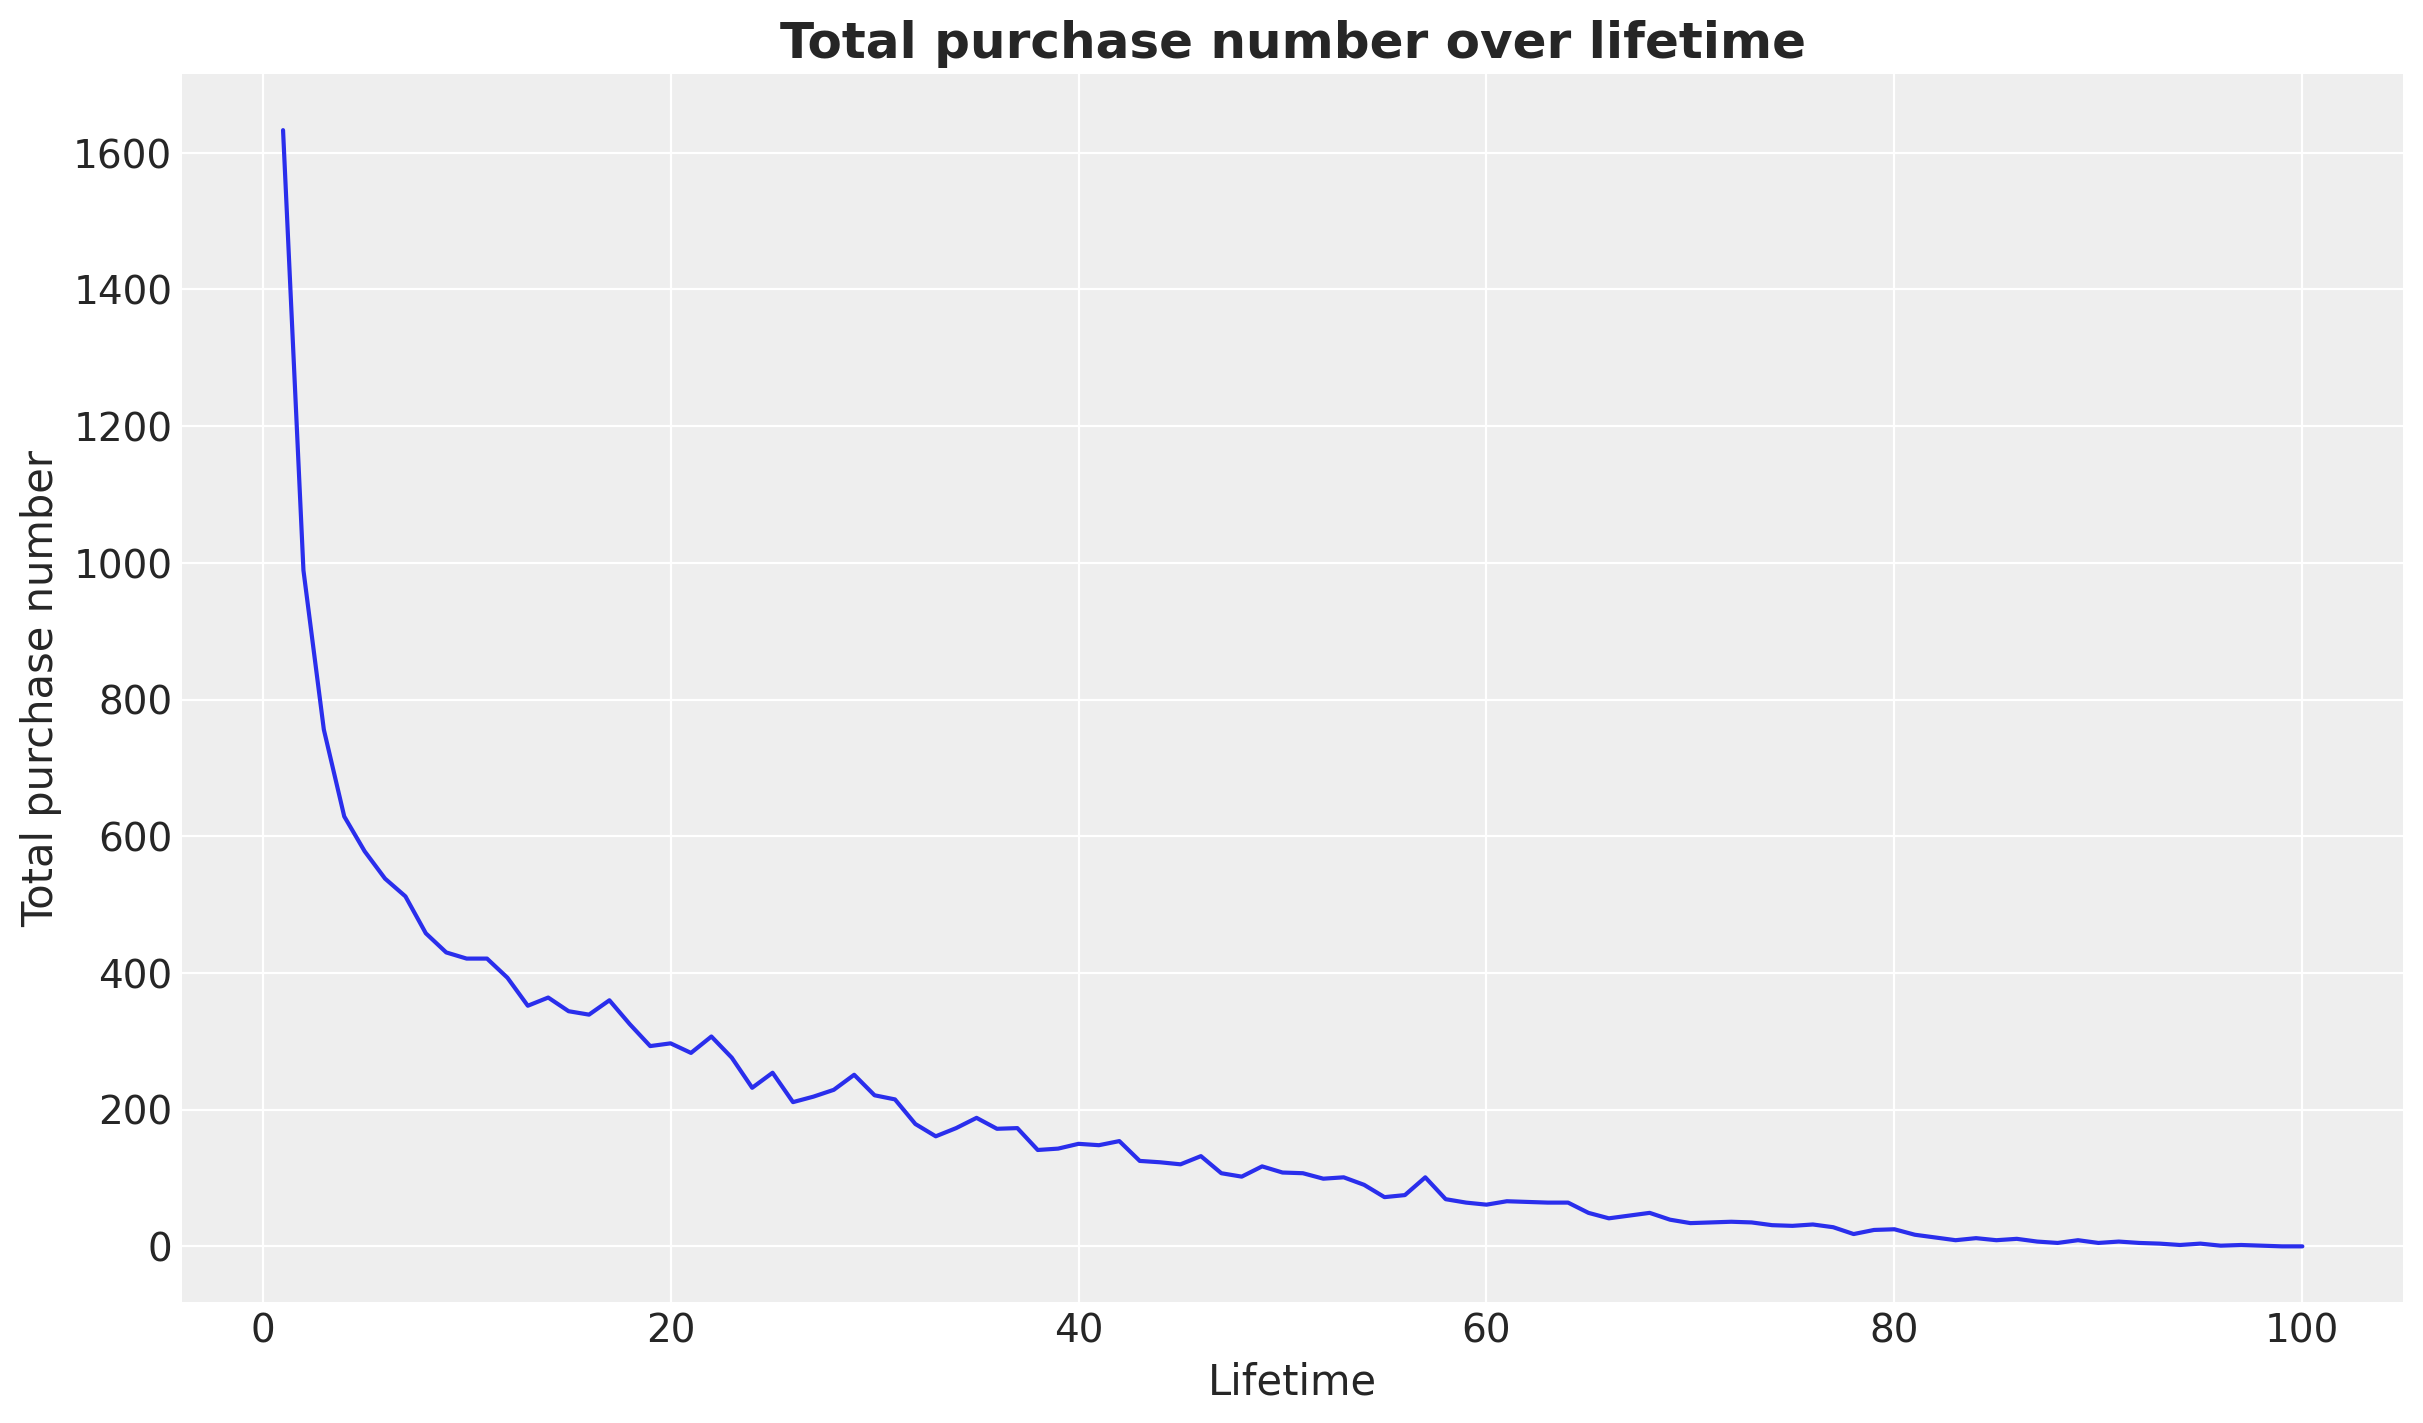

In [21]:
fig, ax = plt.subplots()
data_df.group_by("l").agg(pl.col("y").sum().alias("total_y")).pipe(
    lambda df: sns.lineplot(data=df, x="l", y="total_y", ax=ax)
)
ax.set(xlabel="Lifetime", ylabel="Total purchase number")
ax.set_title("Total purchase number over lifetime", fontsize=18, fontweight="bold");

## Train Test Split

In [59]:
data_df["fs"].max()

69

In [76]:
fs_threshold = data_df["fs"].max() + 1

data_df = data_df.with_columns(idx_id=pl.col("id").sort().rank("dense"))

train_df = data_df.filter(pl.col("t") <= fs_threshold)
test_df = data_df.filter(pl.col("t") > fs_threshold)

In [77]:
assert set(train_df["id"].unique()) == set(test_df["id"].unique())